In [ ]:
from models import *
from glob import glob
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
 
# list of adcs we would like to analyse 
adcs = ['XFEL.DIAG/BPM/BPME.2241.SA1', 'XFEL.DIAG/BPM/BPME.2247.SA1', 'XFEL.DIAG/BPM/BPME.2253.SA1', 'XFEL.DIAG/BPM/BPME.2259.SA1', 'XFEL.DIAG/BPM/BPME.2265.SA1', 'XFEL.DIAG/BPM/BPME.2271.SA1', 'XFEL.DIAG/BPM/BPME.2278.SA1', 'XFEL.DIAG/BPM/BPME.2284.SA1', 'XFEL.DIAG/BPM/BPME.2290.SA1', 'XFEL.DIAG/BPM/BPME.2296.SA1', 'XFEL.DIAG/BPM/BPME.2302.SA1', 'XFEL.DIAG/BPM/BPME.2308.SA1', 'XFEL.DIAG/BPM/BPME.2314.SA1', 'XFEL.DIAG/BPM/BPME.2320.SA1', 'XFEL.DIAG/BPM/BPME.2326.SA1', 'XFEL.DIAG/BPM/BPME.2332.SA1', 'XFEL.DIAG/BPM/BPME.2339.SA1', 'XFEL.DIAG/BPM/BPME.2345.SA1', 'XFEL.DIAG/BPM/BPME.2351.SA1', 'XFEL.DIAG/BPM/BPME.2357.SA1', 'XFEL.DIAG/BPM/BPME.2363.SA1', 'XFEL.DIAG/BPM/BPME.2369.SA1', 'XFEL.DIAG/BPM/BPME.2375.SA1', 'XFEL.DIAG/BPM/BPME.2381.SA1', 'XFEL.DIAG/BPM/BPME.2387.SA1', 'XFEL.DIAG/BPM/BPME.2393.SA1', 'XFEL.DIAG/BPM/BPME.2400.SA1', 'XFEL.DIAG/BPM/BPME.2406.SA1', 'XFEL.DIAG/BPM/BPME.2412.SA1', 'XFEL.DIAG/BPM/BPME.2418.SA1', 'XFEL.DIAG/BPM/BPME.2424.SA1', 'XFEL.DIAG/BPM/BPME.2430.SA1', 'XFEL.DIAG/BPM/BPME.2436.SA1', 'XFEL.DIAG/BPM/BPME.2442.SA1', 'XFEL.DIAG/BPM/BPME.2448.SA1', 'XFEL.DIAG/BPM/BPME.2454.SA1', 'XFEL.DIAG/BPM/BPME.2461.SA1', 'XFEL.DIAG/BPM/BPME.2806.SA3', 'XFEL.DIAG/BPM/BPME.2812.SA3', 'XFEL.DIAG/BPM/BPME.2818.SA3', 'XFEL.DIAG/BPM/BPME.2824.SA3', 'XFEL.DIAG/BPM/BPME.2830.SA3', 'XFEL.DIAG/BPM/BPME.2836.SA3', 'XFEL.DIAG/BPM/BPME.2842.SA3', 'XFEL.DIAG/BPM/BPME.2849.SA3', 'XFEL.DIAG/BPM/BPME.2855.SA3', 'XFEL.DIAG/BPM/BPME.2861.SA3', 'XFEL.DIAG/BPM/BPME.2867.SA3', 'XFEL.DIAG/BPM/BPME.2873.SA3', 'XFEL.DIAG/BPM/BPME.2879.SA3', 'XFEL.DIAG/BPM/BPME.2885.SA3', 'XFEL.DIAG/BPM/BPME.2891.SA3', 'XFEL.DIAG/BPM/BPME.2897.SA3', 'XFEL.DIAG/BPM/BPME.2903.SA3', 'XFEL.DIAG/BPM/BPME.2910.SA3', 'XFEL.DIAG/BPM/BPME.2916.SA3', 'XFEL.DIAG/BPM/BPME.2922.SA3', 'XFEL.DIAG/BPM/BPME.2928.SA3', 'XFEL.DIAG/BPM/BPME.2934.SA3', 'XFEL.DIAG/BPM/BPME.2940.SA3', 'XFEL.DIAG/BPM/BPME.2944.SA3', 'XFEL.DIAG/BPM/BPME.2947.SA3', 'XFEL.DIAG/BPM/BPME.2951.SA3', 'XFEL.DIAG/BPM/BPME.2955.SA3']
# getting list of available training files
files = sorted(glob('data/orbits/*.pickle'))
epochs = 256

ma = lambda x,N : np.convolve(x, np.ones(N)/N, mode='valid')


In [ ]:
# loading data to a torch tensor
X = [get_X_from_file(file,adcs) for file in tqdm(files)]
print(X[0].shape)

## Showing Data

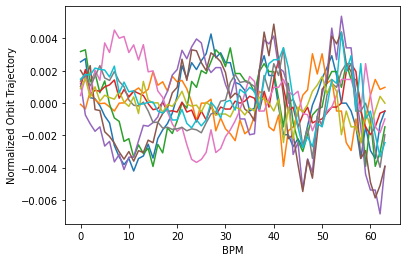

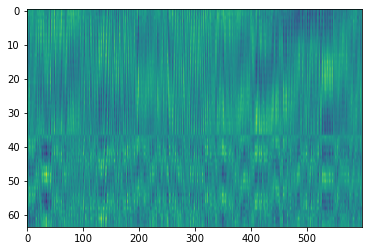

In [5]:
plt.plot(X[0][:10,0,:64].T)
plt.xlabel('BPM')
plt.ylabel('Normalized Orbit Trajectory')
plt.show()
plt.imshow(X[0][:,0,:64].float().T, aspect = 'auto')
plt.show()

## Model
just RNN (GRU(64,16)) -> Linear(16,16) -> |enc(x) - c|_2 

In [10]:
class RNNOrbitAnomalyDetector(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(RNNOrbitAnomalyDetector, self).__init__()
        self.rnn = nn.GRU(input_dim, embedding_dim, bias = False)
        self.linear = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim, bias = False))
        
        self.c = nn.Parameter(torch.randn(embedding_dim),requires_grad = False)
    
    def phi(self, x):
        '''
        This function is the encoder which embeds inputs 
        '''
        # rnn returns two tuples, first is output, the second are hidden states
        return self.linear(self.rnn(x)[0])
    
    def forward(self, x):
        phi = self.phi(x)
        return torch.linalg.vector_norm(phi - self.c, dim = -1)
    

model = RNNOrbitAnomalyDetector(64, 16)
optimizer = optim.Adam(model.parameters(), lr = 0.1)
losses = []

X_test = X[:1]
X_train = X[1:]
model.load_state_dict(torch.load('./trained_models/orbits/model_255'))

cavity.ipynb  data  models.py  orbit.ipynb  __pycache__  trained_models


<All keys matched successfully>

## Training Loop

In [ ]:
for epoch in tqdm(range(epochs)):
    y = [model(x[:,0,:64].unsqueeze(0).float()) for x in tqdm(X_train)]
    y = torch.cat(y,1).flatten()
    
    # optimisation 
    loss = y.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 50 == 0:
        plt.plot(losses)
        plt.show()
        
# torch.save(model.state_dict(),'trained_models/orbits/model_' + str(epoch),)

## Point Anomaly
one location is noisy with increasing normal noise

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

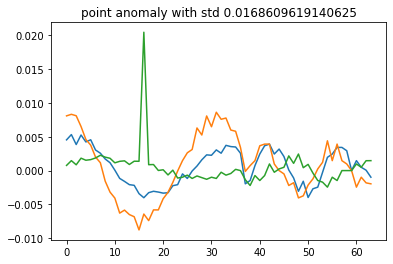

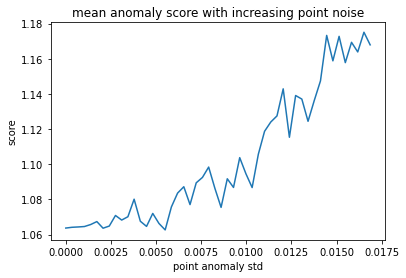

In [28]:
std = torch.tensor([x.std() for x in tqdm(X)]).mean()
s = {}
x = X_train[1][:,0,:64].unsqueeze(0).float().clone()
i = torch.tensor([16]) #torch.randint(0,x_test.shape[-1],(1,))

for noise in tqdm(list(np.linspace(0,10 * std,50))):
    with torch.no_grad():        
        x[0,:,i] = noise * torch.randn(x.shape[1],1)
        s[noise] = model(x).mean()
        
plt.plot(x[0,:3,:].T)
plt.title(f'point anomaly with std {noise}')
plt.show()
plt.plot(s.keys(), s.values())
plt.xlabel('point anomaly std')
plt.ylabel('score')
plt.title('mean anomaly score with increasing point noise')
plt.show()

## Point Anomaly
Randomizing n frames from 10th frame

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Anomaly score for ranomized frames from 10th frame')

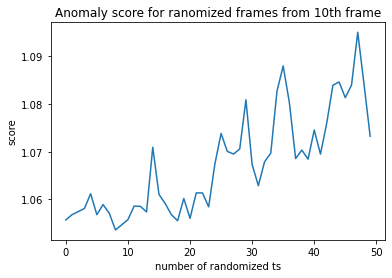

In [30]:
std = torch.tensor([x.std() for x in tqdm(X)]).mean()
x = X_train[1][:,0,:64].unsqueeze(0).float().clone()
s = {}

with torch.no_grad():        
    s[0] = model(x).mean().detach()
    for i in range(1,50):
        x[0,10:10+i,:] += std * torch.randn(1,x.shape[-1])
        s[i] = model(x).mean()
plt.plot(s.keys(),s.values())
plt.xlabel('number of randomized ts')
plt.ylabel('score')
plt.title('Anomaly score for ranomized frames from 10th frame')

## Semantic Anomaly
Flipping n-th value before end of sequence

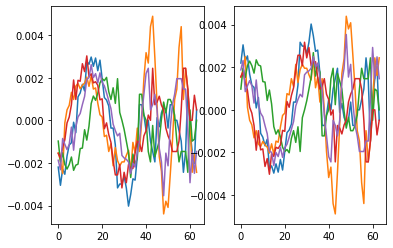

Text(0.5, 1.0, 'Anomaly score for flipped values')

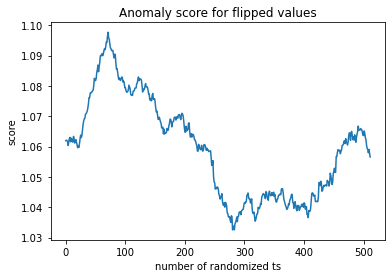

In [33]:
# std = torch.tensor([x.std() for x in tqdm(X)]).mean()
x = X_test[0][:,0,:64].unsqueeze(0).float().clone()
s = {}

with torch.no_grad():        
    s[0] = model(x).mean().detach()
    for i in range(1,512):
        x_ = x.clone()
        x_[0,-i:,:] = -x_[0,-i:,:] 
        s[i] = model(x_).mean()
    plt.subplot(121)
    plt.plot(x[0,550:555,:].T)
    plt.subplot(122)
    plt.plot(x_[0,550:555,:].T)
    plt.show()
plt.plot(s.keys(),s.values())
plt.xlabel('number of randomized ts')
plt.ylabel('score')
plt.title('Anomaly score for flipped values')